In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import polyphase as phase
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [3]:
htedf = pd.read_pickle('../data/htev2.pkl')
htedf.head()

,solvent,SM,polymer,chi12,chi13,chi23,dop,delta_solv,delta_SM,delta_polymer
0,Acetone,PC61BM,MDMO-PPV,0.440066,1.478520,1.90338,"[1626.0162601626018, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.62, 5.28]"
1,Acetone,PC61BM,MEH-PPV,0.458907,1.532581,1.90338,"[948.509485094851, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.38, 5.44]"
2,Acetone,PC61BM,P3HT,0.630290,2.719685,1.90338,"[117.82726522917405, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.56, 2.88, 3.19]"
3,Acetone,PC61BM,PFO,0.660927,2.507620,1.90338,"[1200.4944610849618, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.55, 2.8, 4.51]"
4,Acetone,PC61BM,PM6,0.468860,1.896708,1.90338,"[1436.3143631436315, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.37, 4.36, 4.19]"


In [4]:
sys_ds = htedf[(htedf['solvent']=='Toluene')&(htedf['SM']=='DPP(TBFu)2')&(htedf['polymer']=='PFO')]
M = sys_ds['dop'].values[0]
chi = [sys_ds['chi12'].values[0], sys_ds['chi13'].values[0], sys_ds['chi23'].values[0]]
sys_ds

,solvent,SM,polymer,chi12,chi13,chi23,dop,delta_solv,delta_SM,delta_polymer
3543,Toluene,DPP(TBFu)2,PFO,0.664428,0.705938,1.679409,"[831.1115499818967, 7.101313320825517, 1]","[18.0, 1.4, 2.0]","[19.33, 4.78, 6.26]","[18.55, 2.8, 4.51]"


2020-10-08 17:06:38,247	INFO resource_spec.py:212 -- Starting Ray with 119.87 GiB memory available for workers and up to 55.39 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-08 17:06:38,548	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-10-08 17:06:38,824	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


3-dimensional grid generated at 0.03s
Using beta (=1.00E-04) correction for energy landscape
Energy computed at 0.11s
Energy is corrected at 0.11s
Convexhull is computed at 0.13s
Using 1.43E-01 as a threshold for Laplacian of a simplex
Total of 1949 simplices in the convex hull
Simplices are labelled at 6.66s
Labels are lifted at 7.15s
Total 28/1949 coplanar simplices
Computation took 7.16s


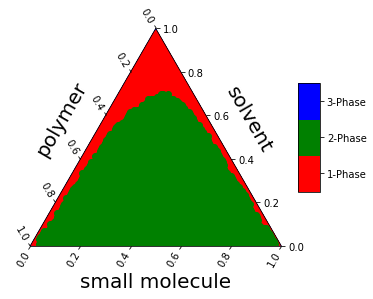

In [56]:
M = [5,5,1]
chi = [1, 0.5, 1]

configuration = {'M':M, 'chi':chi}

meshsize = 100
kwargs = {
    'flag_refine_simplices':True,
    'flag_lift_label': True,
    'use_weighted_delaunay': False,
    'flag_remove_collinear' : False, 
    'beta':1e-4, # not used 
    'flag_make_energy_paraboloid': False, 
    'pad_energy': 2,
    'flag_lift_purecomp_energy': False,
    'threshold_type':'uniform',
    'thresh_scale':0.1*meshsize,
    'lift_grid_size':meshsize,
    'verbose' : True
 }

out = phase.compute(configuration,meshsize, **kwargs) 
grid = out['grid']
num_comps = out['num_comps']
simplices = out['simplices']
energy = out['energy']
phase.plot_lifted_label_ternary(out['output'])
plt.show()

# 1. Visual tests

1. Plot convex hull and energy landscape

In [32]:
MIN_POINT_PRECISION = 1e-8
from collections import Counter

def is_boundary_point(point):
    if np.isclose(point, MIN_POINT_PRECISION).any():
        return True
    else:
        return False
    
def is_pure_component(point):
    counts = Counter(point)
    if counts[MIN_POINT_PRECISION]>1:
        return True
    else:
        return False
    
boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
pure_points = np.asarray([is_pure_component(x) for x in grid.T])

In [39]:
# compare energy landscape before and after some corrections. 
# Manually edit the variables and subplot titles

from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2,
                    specs=[[{'is_3d': True}, {'is_3d': True}]], subplot_titles=('w/o boundary points','w/ beta correction'),
                    print_grid=False)

x, y, z = grid[0,~boundary_points], grid[1,~boundary_points], energy[~boundary_points]
#fig_00 = go.Mesh3d(x=x, y=y, z=z, color='blue')
fig_00 =go.Scatter3d(x=x, y=y, z=z, mode='markers', marker = dict(color='blue'))
fig.append_trace(fig_00,row=1, col=1)
fig.update_layout(scene_aspectmode='cube')
fig.update_layout(scene = dict(xaxis_title='polymer',yaxis_title='SM',zaxis_title='Energy'))

x, y, z = grid[0,:], grid[1,:], energy
#fig_01 =go.Mesh3d(x=x, y=y, z=z, color='blue')
fig_01 =go.Scatter3d(x=x, y=y, z=z, mode='markers', marker = dict(color='blue'))
fig.append_trace(fig_01,row=1, col=2)
fig.update_layout(scene2_aspectmode='cube')
fig.update_layout(scene2 = dict(xaxis_title='polymer',yaxis_title='SM',zaxis_title='Energy'))

fig.update_layout(template='plotly_white')

fig.write_html('../figures/3dplots/EL_betacorrection.html')


2020-10-08 22:50:11,368	INFO resource_spec.py:212 -- Starting Ray with 119.53 GiB memory available for workers and up to 55.23 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-08 22:50:11,689	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-10-08 22:50:12,015	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


Computation took 7.97s


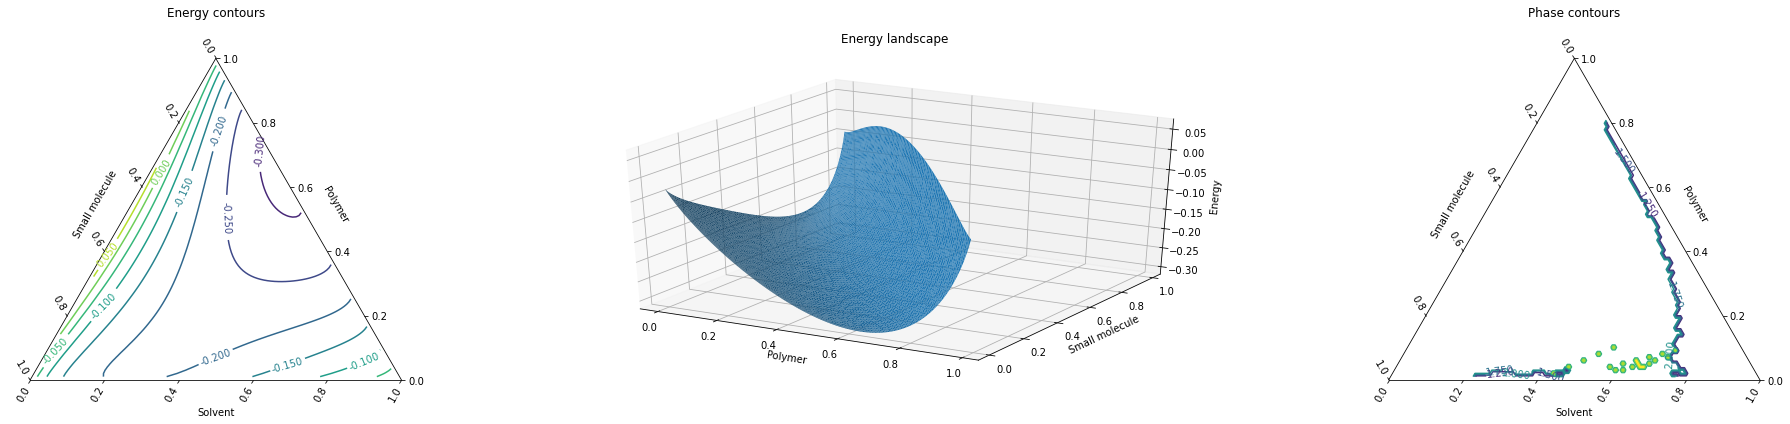

In [92]:
# Mesh size vs Energy surface
def makeAxis(title, tickangle):
    return {
      'title': title,
      'titlefont': { 'size': 20 },
      'tickangle': tickangle,
      'tickfont': { 'size': 15 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

def plotly_ternary_surface(grid, energy, num_comps):
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': "ternary"}, {'is_3d': True}]], 
                    subplot_titles=('Phase diagram','Energy landscape'),
                    print_grid=False)
    
    fig_00 = ff.create_ternary_contour(grid, num_comps,
                                    pole_labels=['polymer', 'SM', 'solvent'],
                                    interp_mode='cartesian',
                                    ncontours=3,
                                    coloring='lines')
    
    for i in fig_00.data:
        fig.append_trace(i, row=1, col=1)
        
    boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
    x, y, z = grid[0,~boundary_points], grid[1,~boundary_points], energy[~boundary_points]
    fig_01 = go.Mesh3d(x=x, y=y, z=z, color='blue')
    fig.append_trace(fig_01,row=1, col=2)
    fig.update_layout(scene1 = dict(xaxis_title='polymer',yaxis_title='SM',zaxis_title='Energy',aspectmode='cube'))

    fig.update_layout(template='plotly_white')
    #fig.update_layout(showlegend=False)
    fig.update_layout({'ternary': {'sum': 100,
                                   'aaxis': makeAxis('Polymer', 0),
                                   'baxis': makeAxis('<br>Small Molecule', 45),
                                   'caxis': makeAxis('<br>Solvent', -45)}
                      })
    fig.layout.annotations[0].update(x=0.025)
    fig.layout.annotations[1].update(x=0.65)
    
    return fig


def plt_ternary_surface(grid, energy, num_comps):
    fig = plt.figure(figsize=(3*6*1.6,6))
    ax1 = fig.add_subplot(1,3,2, projection='3d')
    ax1.plot_trisurf(grid[0,:], grid[1,:], energy, linewidth=0.01, antialiased=True)
    ax1.set_xlabel('Polymer')
    ax1.set_ylabel('Small molecule')
    ax1.set_zlabel('Energy')
    ax1.set_title('Energy landscape', pad=42)
    
    ax2 = fig.add_subplot(1, 3, 1, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], energy)
    ax2.set_title("Energy contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    ax2 = fig.add_subplot(1, 3, 3, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], num_comps)
    ax2.set_title("Phase contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    plt.tight_layout()
    return

for m in [100,200,300,400]:
    
    out = phase.compute(configuration,m, 
                        flag_lift_label= True,lift_grid_size=m) 
    grid = out['grid']
    energy = out['energy']
    num_comps = out['output'].loc['label',:].to_numpy()
    boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
    
    plt_ternary_surface(grid[:,~boundary_points], energy[~boundary_points], num_comps[~boundary_points])
    plt.savefig('../figures/notebooks/{}.png'.format(m), dpi=500, bbox_inches='tight')
    plt.show()
    
#     fig = plotly_ternary_surface(grid, num_comps)
#     fig.show(renderer="notebook")
    break

# Centroid tests

For 3-phase simplices, energy at the centroid should be lesser than that of the vertices

In [98]:
m = 100
out = phase.compute(configuration,m, 
                    flag_lift_label= True,lift_grid_size=m) 
grid = out['grid']
energy = out['energy']
simplices = out['simplices']
num_comps = out['num_comps']

X = out['output']
CHI = phase._utri2mat(configuration['chi'], 3)

2020-10-08 23:36:14,446	INFO resource_spec.py:212 -- Starting Ray with 119.53 GiB memory available for workers and up to 55.22 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-08 23:36:14,759	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-10-08 23:36:15,061	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


Computation took 8.62s
137


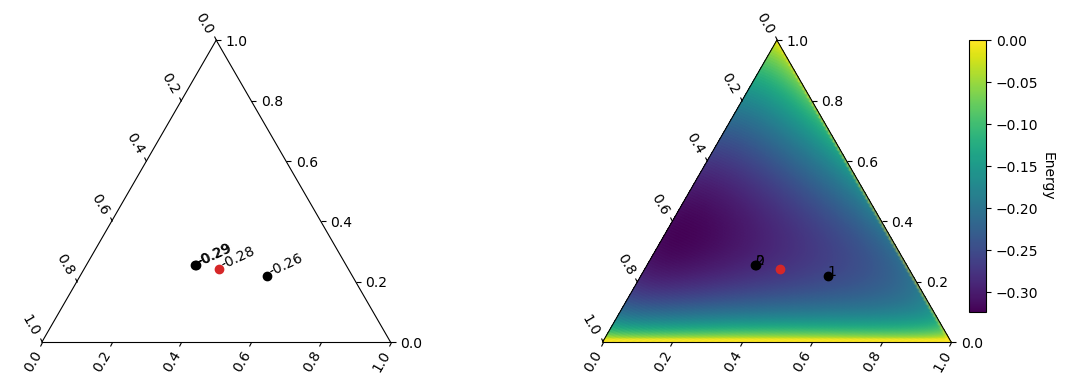

In [44]:
fig, axs = plt.subplots(1,2,subplot_kw={'projection':'ternary'}, dpi=100, figsize=(2*4*1.6, 4))
fig.subplots_adjust(wspace=0.3)
energy = out['energy']

cs = axs[1].scatter(X.loc['Phi_3',:], X.loc['Phi_1',:], X.loc['Phi_2',:],c=out['energy'])
cax = axs[1].inset_axes([1.05, 0.1, 0.05, 0.9], transform=axs[1].transAxes)
colorbar = fig.colorbar(cs, cax=cax)
colorbar.set_label('Energy', rotation=270, va='baseline')
Cx, Cy, Cz = 0,0,0
for num,i in enumerate(phase3[ind]):
    # follow the order in the phase diagram visualization phi3, phi1, phi2
    x,y,z = X.loc['Phi_3',i], X.loc['Phi_1',i], X.loc['Phi_2',i]
    axs[1].scatter(x,y,z, color='k')
    axs[1].text(x,y,z,str(num))
    axs[0].scatter(x,y,z, color='k')
    axs[0].text(x,y,z,'{:.2f}'.format(energy[i]), rotation=25.)
    Cx += x
    Cy += y
    Cz += z
    
#ax.scatter(centroid_threeD[2], centroid_threeD[0], centroid_threeD[1], color='tab:red',marker='o') 
axs[1].scatter(Cx/3, Cy/3, Cz/3, color='tab:red',marker='o') 
axs[0].scatter(Cx/3, Cy/3, Cz/3, color='tab:red',marker='o')
Cenergy = phase.flory_huggins([Cy/3, Cz/3, Cx/3],configuration['M'],CHI,beta=0.0)    
axs[0].text(Cx/3, Cy/3, Cz/3,'{:.2f}'.format(Cenergy), rotation=25.)
plt.show()

# 3. Common tangent test
There's a chance that this would not work because of [sub-derivative of a convex functions](https://en.wikipedia.org/wiki/Subderivative). So not being able to match the local derivatives at any tangent plane is fine because you're working with a discrete surface approximation of the energy landscape.

8
[0.92929293 0.01010102 0.06060607] 1.0000000199999999
[0.01010102 0.95959596 0.03030304] 1.0000000199999999
[0.01010102 0.94949495 0.04040405] 1.0000000199999999
0 Magnitude : 2.95 angle : 32.89
1 Magnitude : 1.95 angle : 64.59
2 Magnitude : 1.60 angle : 69.27


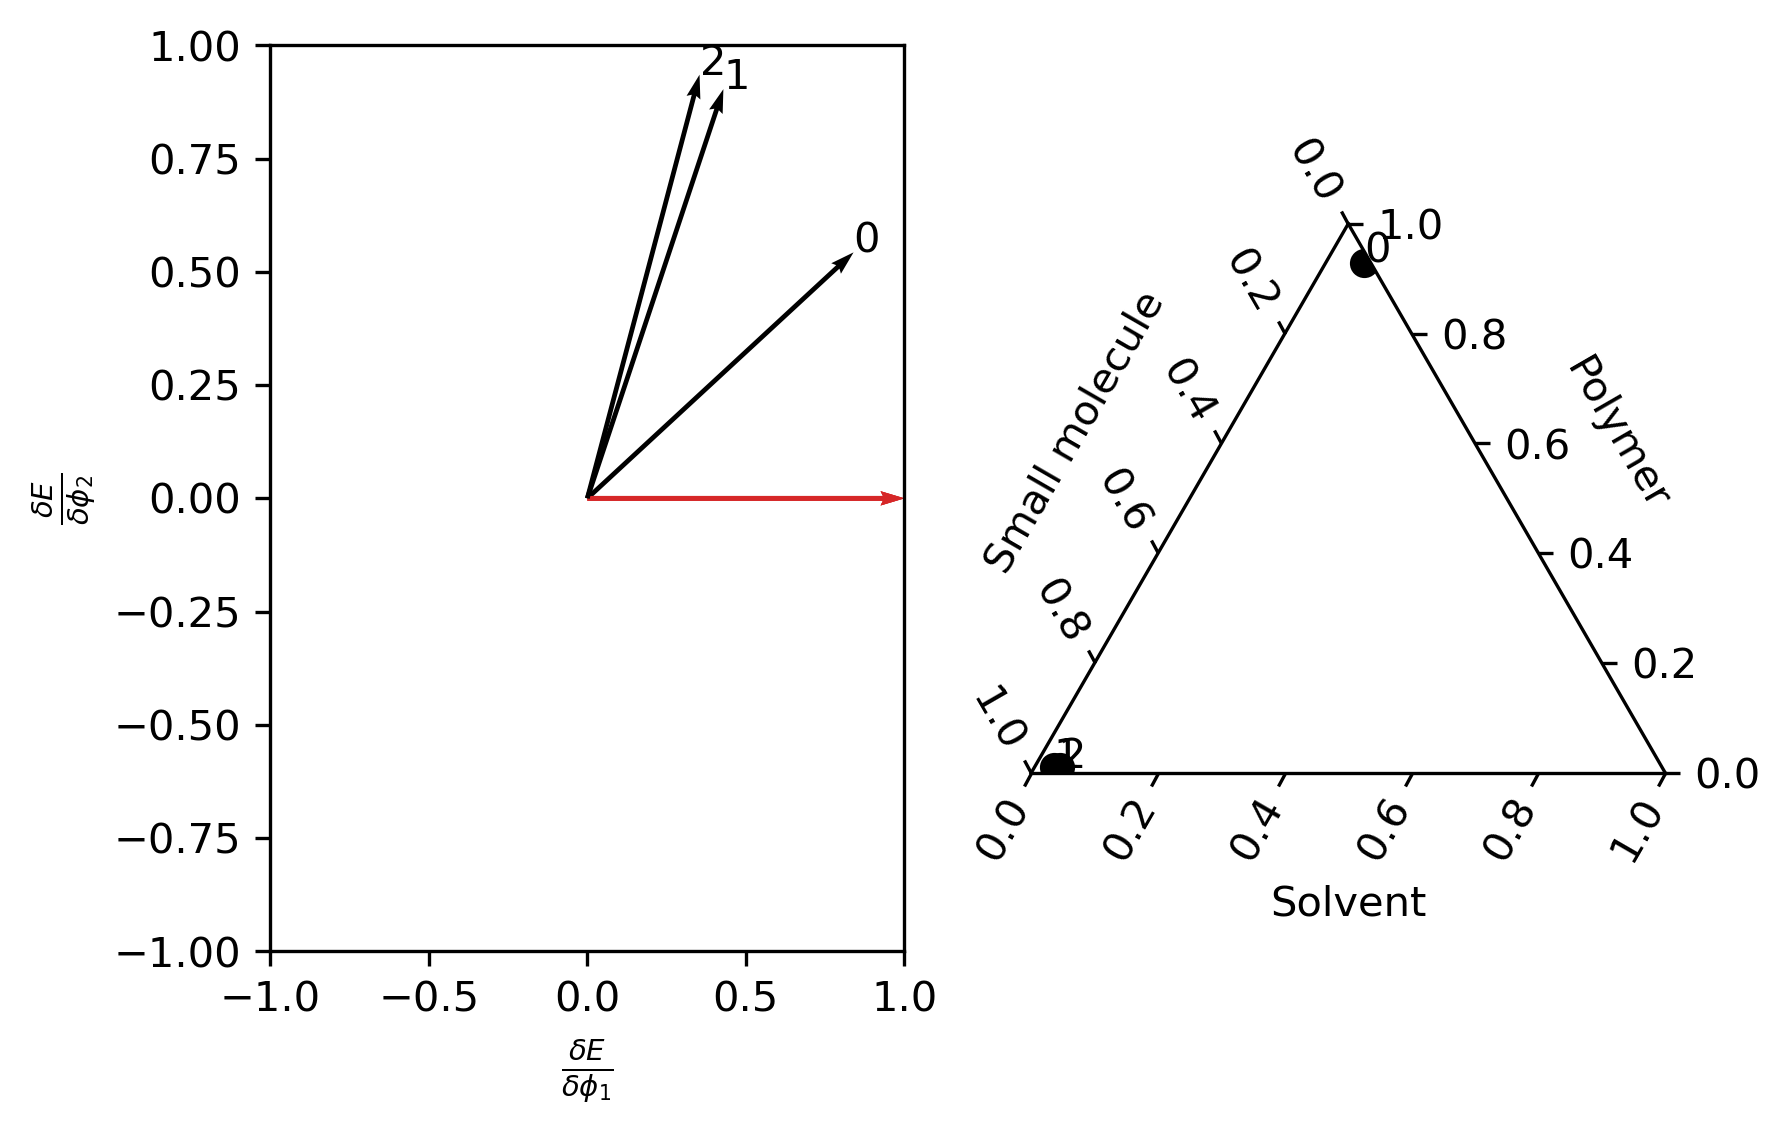

In [117]:
chi = configuration['chi']
M = configuration['M']
CHI = phase._utri2mat(chi, len(M))
phase3 = np.asarray(simplices)[np.asarray(num_comps)==2]
ind = np.random.randint(len(phase3))
print(ind)

def threecomp_gradphi(x):
    dEdx1 = (1/M[0])*(1+np.log(x[0])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] +\
    CHI[0,2] - 2*CHI[0,2]*x[0] - CHI[0,2]*x[1] - CHI[1,2]*x[1]
    
    dEdx2 = (1/M[1])*(1+np.log(x[1])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] -\
    CHI[0,2]*x[0] + CHI[1,2] - 2*CHI[1,2]*x[1]  - CHI[1,2]*x[0]    
    
    return [dEdx1, dEdx2]

vertices = X.iloc[:3,phase3[ind]].to_numpy().T
grads = []
for v in vertices:
    print(v, np.sum(v))
    grads.append(threecomp_gradphi(v))

fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='ternary')
for i, (v,w) in enumerate(zip(grads, vertices)):
    magnitude = np.linalg.norm(v)
    unitvec = v/magnitude
    angle = np.degrees(np.arccos(np.clip(np.dot(np.array([1,0]), unitvec), -1.0, 1.0)))

    print(i, 'Magnitude : {:.2f}'.format(magnitude), 'angle : {:.2f}'.format(angle))
    ax1.quiver(0,0,1,0,angles='xy', scale_units='xy',scale=1, ls='--', lw=2.0, color='tab:red')
    ax1.quiver(0, 0, unitvec[0], unitvec[1], angles='xy', scale_units='xy', scale=1)
    ax1.text(unitvec[0], unitvec[1], str(i))
    ax2.scatter(w[0], w[1], w[2], color='k')
    ax2.text(w[0], w[1], w[2], str(i))
    
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xlabel(r'$\frac{\delta E}{\delta\phi_1}$')
ax1.set_ylabel(r'$\frac{\delta E}{\delta\phi_2}$')

ax2.set_tlabel('Polymer')
ax2.set_llabel('Small molecule')
ax2.set_rlabel('Solvent')

ax2.taxis.set_label_position('tick1')
ax2.laxis.set_label_position('tick1')
ax2.raxis.set_label_position('tick1')
plt.show()

In [30]:
# number of simplices
from scipy.spatial import Delaunay
points = X.loc[['Phi_1','Phi_2'],:].to_numpy().T
tri = Delaunay(points)
print('Total of {} simplices in delaunay triangulation of original energy landscape'.format(len(tri.simplices)))

(225743, 2)
Total of 90593 simplices in delaunay triangulation of original energy landscape


In [57]:
QR = vertices[0] - vertices[1]
QS = vertices[0] - vertices[2]
normal = np.cross(QR, QS)
normal/np.linalg.norm(normal)

array([0.57735027, 0.57735027, 0.57735027])

import autograd.numpy as anp
from autograd import grad
import pdb
from itertools import combinations

chi = [3]
M = [1,1]
CHI = phase._utri2mat(chi, len(M))
combs = combinations(anp.arange(len(M)),2)
pairs = [c for c in combs]

def flory_huggins(x):
    T1 = 0
    T2 = 0
    x = anp.asarray(x)
    xend = 1-anp.sum(x[:-1])
    
    for i,xi in enumerate(x):
        T1 = T1+ (xi*anp.log(xi))/M[i]

    for i,j in pairs:
        T2 = T2+ CHI[i,j]*x[i]*x[j] 
        
    return T1+T2  

def twocomp_energy(x):
    return x*(np.log(x)) + (1-x)*np.log(1-x) + chi[0]*x*(1-x)

def twocomp_gradphi(x):
    return np.log(x/(1-x))+chi[0]*(1-2*x)

phi = 0.5

energy_result = flory_huggins([phi, 1-phi])
energy_expected = twocomp_energy(phi)
assert np.isclose(energy_result, energy_expected), 'Expected {:.2f} got {:.2f}'.format(energy_expected, energy_result)

grad_FH = grad(flory_huggins)
grad_result = grad_FH([phi, 1-phi])[0]
grad_expected = twocomp_gradphi(phi)
assert np.isclose(grad_result, grad_expected), 'Expected {:.2f} got {:.2f}'.format(grad_expected, grad_result)